In [265]:
# jupyter setup for reloading modules
# %load_ext autoreload
# %autoreload 2


In [266]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import sqlite3
from paths import PF_DB_PATH, DATA_DIR, AUS_PATH
from IPython.display import Markdown as md
from IPython.display import display
import os

DEBUG = True
PALETTE_TWO_COLOR = ['#3891ff','#9ca3ba']

In [267]:
def dist(lat1, lon1, lat2, lon2):
    # calculate distance between two coordinates
    return np.sqrt((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2) * 60 * 1.852


In [268]:
def display_list(lst: list, sep=", ") -> str:
    # join list items to return a merged str for display
    return sep.join(lst)


def debug(df):
    # display df only in debug mode
    # - hide df printout when exporting html
    if DEBUG:
        display(df)


def decluter(
    ax,
    show_spines=False,
    show_xaxis=False,
    show_yaxis=False,
    xlabel=None,
    ylabel=None,
    title=None,
    x_use_million=False,
    x_use_unit=None,
    x_use_int= False,
    y_use_million=False,
    y_use_unit=None,
    y_use_int= False,
    ret_ax =False
):
    # declutter chart by removing unneccessary elements
    # remove spines from chart
    ax.spines["top"].set_visible(show_spines)
    ax.spines["right"].set_visible(show_spines)
    ax.spines["bottom"].set_visible(show_spines)
    ax.spines["left"].set_visible(show_spines)
    # remove x axis
    ax.xaxis.set_visible(show_xaxis)
    # handle x axis labels
    ax.set_xlabel(xlabel)
    # format axis
    if x_use_million:
        ax.xaxis.set_major_formatter(lambda x, pos: f"{x/1e6:.1f}M")
    if x_use_unit:
        ax.xaxis.set_major_formatter(lambda x, pos: f"{x} {x_use_unit}")
    if x_use_int:
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # remove y axis
    ax.yaxis.set_visible(show_yaxis)
    # handle y axis label
    ax.set_ylabel(ylabel)
    # format axis
    if y_use_million:
        ax.yaxis.set_major_formatter(lambda x, pos: f"{x/1e6:.1f}M")
    if y_use_unit:
        ax.yaxis.set_major_formatter(lambda x, pos: f"{x} {y_use_unit}")
    if y_use_int:
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    # set title
    ax.set_title(title, loc="left")

    # declutter legend
    legend = ax.get_legend()
    if legend:
        legend.get_frame().set_linewidth(0)
        legend.set_title(None)

    if ret_ax:
        return ax


# Dataset
Data source: https://www.pricefinder.com.au/

This dataset was downloaded as separated `.xlsx` files, which were then merged into a single SQLite database. The SQL database consists of 2 tables:

In [269]:
con = sqlite3.connect(PF_DB_PATH)
raw_records = pd.read_sql_query("SELECT * FROM record", con)
raw_property = pd.read_sql_query("SELECT * FROM property", con)


In [270]:
md(
    f"""
1. records\n
    This table contains {raw_records.shape[0]:,} property sales records, each record contains the following data:
    * `id`: unique identification of the sales record, formed by merging address, postcode and sale date
    * `record_date`: date of sale (from {raw_records.record_date.min()} to {raw_records.record_date.max()})
    * `price`: final sale price
    * `sale_type`: type of sale ({display_list(raw_records.sale_type.unique().tolist())})
    * `prop_id`: id of the property, formed by merging address and postcode
    * `property_type`: type of property ({display_list(raw_records.property_type.unique().tolist())})
    * `bedrooms`: number of bedrooms
    * `bathrooms`: number of bathrooms
    * `carparks`: number of car parks
2. property\n
    This table contains {raw_property.shape[0]:,} properties that have associated sales record(s), each property details consist of the following data:
    * `address`: address with postcode attached, act as unique identification
    * `street`: street name
    * `locality`: suburb name ({raw_property.locality.nunique()} in total)
    * `postcode`: postcode ({raw_property.postcode.nunique()} in total)
    * `land_area`: land area
"""
)



1. records

    This table contains 731,552 property sales records, each record contains the following data:
    * `id`: unique identification of the sales record, formed by merging address, postcode and sale date
    * `record_date`: date of sale (from 2000-01-05 to 2022-01-04)
    * `price`: final sale price
    * `sale_type`: type of sale (Agents Advice - Sale, Normal Sale, Multi-Sale, Part Sale, Unknown)
    * `prop_id`: id of the property, formed by merging address and postcode
    * `property_type`: type of property (Commercial, Unit, Other, House, Vacant Land, Industrial)
    * `bedrooms`: number of bedrooms
    * `bathrooms`: number of bathrooms
    * `carparks`: number of car parks
2. property

    This table contains 455,865 properties that have associated sales record(s), each property details consist of the following data:
    * `address`: address with postcode attached, act as unique identification
    * `street`: street name
    * `locality`: suburb name (844 in total)
    * `postcode`: postcode (312 in total)
    * `land_area`: land area


In [271]:
debug(raw_records.describe(include="all"))
debug(raw_property.describe(include="all"))


,id,record_date,price,sale_type,prop_id,property_type,bedrooms,bathrooms,carparks
count,731552,731552,7.315520e+05,731552,731552,731552,731552.000000,731552.000000,731552.000000
unique,731552,8020,NaN,5,455865,6,NaN,NaN,NaN
top,"SUITE 311/368 SUSSEX ST, 2000_2021-12-16 00:00:00",2021-06-05,NaN,Normal Sale,"81 COURALLIE AVE, 2140",House,NaN,NaN,NaN
freq,1,457,NaN,712227,250,349058,NaN,NaN,NaN
mean,NaN,NaN,8.016123e+05,NaN,NaN,NaN,2.941512,1.758117,1.502566
std,NaN,NaN,2.019461e+06,NaN,NaN,NaN,54.283706,54.234449,2.211600
min,NaN,NaN,0.000000e+00,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,3.420000e+05,NaN,NaN,NaN,2.000000,1.000000,1.000000
50%,NaN,NaN,5.600000e+05,NaN,NaN,NaN,3.000000,2.000000,1.000000
75%,NaN,NaN,8.910000e+05,NaN,NaN,NaN,4.000000,2.000000,2.000000


,address,street,locality,postcode,land_area
count,455865,455865,455865,455865.000000,4.232550e+05
unique,455865,21958,844,NaN,NaN
top,"SUITE 311/368 SUSSEX ST, 2000",PACIFIC HWY,MOSMAN,NaN,NaN
freq,1,3755,2814,NaN,NaN
mean,NaN,NaN,NaN,2152.094122,3.828190e+03
std,NaN,NaN,NaN,79.614767,4.209191e+05
min,NaN,NaN,NaN,2000.000000,0.000000e+00
25%,NaN,NaN,NaN,2089.000000,4.740000e+02
50%,NaN,NaN,NaN,2147.000000,6.890000e+02
75%,NaN,NaN,NaN,2216.000000,1.170000e+03


# Data Cleaning

In [272]:
# raw dataframe
df_raw = pd.merge(
    raw_records, raw_property, left_on="prop_id", right_on="address", how="left"
).drop(columns=["prop_id"])

# filtered dataframe
last_record_date = "2021-12-31"
df_clean = df_raw.query(
    f"0<=bedrooms<=5 & 0<bathrooms<=5 & 0<=carparks <=3 & price >1000"
)
df_clean = df_clean[df_clean.record_date <= last_record_date]
df_clean["year"] = pd.DatetimeIndex(df_clean.record_date).year


In [273]:
md(
    f"""
There is no missing values in both tables. For `records`, unusually high number of bedrooms, bathrooms and car parks were found, possible due to the sale of buildings as a whole. For normal household, only properties with maximum 5 bedrooms/bathrooms and 3 car parks were considered.

On the other hand, it was noticed that some records show abnormally low prices. These records (specifically, all records with price less than $1,000) were removed from the analysis.

Also, to aid yearly aggregation, a `year` column was generated from `record_date`. It should be noted that only sales records on or before {last_record_date} were considered to ensure accuracy of annual statistics.

Consequently, a combined dataset was then formed by merging the two tables with left join on `records`. The final dataset for analysis consists of {df_clean.shape[0]:,} records ({df_clean.shape[0]/df_raw.shape[0]:.0%} of available records).

"""
)



There is no missing values in both tables. For `records`, unusually high number of bedrooms, bathrooms and car parks were found, possible due to the sale of buildings as a whole. For normal household, only properties with maximum 5 bedrooms/bathrooms and 3 car parks were considered.

On the other hand, it was noticed that some records show abnormally low prices. These records (specifically, all records with price less than $1,000) were removed from the analysis.

Also, to aid yearly aggregation, a `year` column was generated from `record_date`. It should be noted that only sales records on or before 2021-12-31 were considered to ensure accuracy of annual statistics.

Consequently, a combined dataset was then formed by merging the two tables with left join on `records`. The final dataset for analysis consists of 641,588 records (88% of available records).



In [274]:
debug(raw_records.isna().sum())
debug(raw_property.isna().sum())
debug(df_clean.describe(include="all").style.format(dict(price="{:,.0f}")))


id               0
record_date      0
price            0
sale_type        0
prop_id          0
property_type    0
bedrooms         0
bathrooms        0
carparks         0
dtype: int64

address          0
street           0
locality         0
postcode         0
land_area    32610
dtype: int64

,id,record_date,price,sale_type,property_type,bedrooms,bathrooms,carparks,address,street,locality,postcode,land_area,year
count,641588,641588,"641,588",641588,641588,641588.000000,641588.000000,641588.000000,641588,641588,641588,641588.000000,590382.000000,641588.000000
unique,641588,8006,nan,5,6,nan,nan,nan,413923,21305,829,nan,nan,nan
top,"3708/343-357 PITT ST, 2000_2021-12-14 00:00:00",2021-06-05,nan,Normal Sale,Unit,nan,nan,nan,"81 COURALLIE AVE, 2140",PACIFIC HWY,CAMPERDOWN,nan,nan,nan
freq,1,428,nan,629621,332896,nan,nan,nan,247,6095,4114,nan,nan,nan
mean,nan,nan,"829,704",nan,nan,2.737126,1.614366,1.361282,nan,nan,nan,2149.246400,5531.859969,2010.971758
std,nan,nan,"1,937,089",nan,nan,1.036375,0.698861,0.672205,nan,nan,nan,80.515402,663394.783778,6.364510
min,nan,nan,"1,050",nan,nan,0.000000,1.000000,0.000000,nan,nan,nan,2000.000000,0.000000,2000.000000
25%,nan,nan,"385,000",nan,nan,2.000000,1.000000,1.000000,nan,nan,nan,2087.000000,465.000000,2006.000000
50%,nan,nan,"590,000",nan,nan,3.000000,2.000000,1.000000,nan,nan,nan,2144.000000,701.000000,2012.000000
75%,nan,nan,"900,000",nan,nan,3.000000,2.000000,2.000000,nan,nan,nan,2213.000000,1393.000000,2016.000000


Further analysis suggested that most records were `Normal Sales` of either `House` or `Unit` properties. For simplicity and sake of interest, only these records were considered.

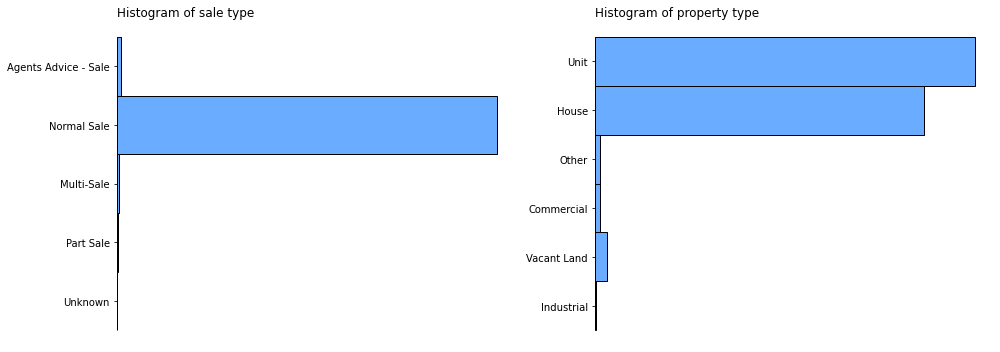

In [307]:
nrow, ncol = 1, 2
fig, axs = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
axs = iter(axs.ravel())

# sale type
ax = next(axs)
sns.histplot(data=df_clean, y="sale_type", ax=ax, color=PALETTE_TWO_COLOR[0])
decluter(ax, show_yaxis=True, title="Histogram of sale type")

# property type
ax = next(axs)
sns.histplot(data=df_clean, y="property_type", ax=ax, color=PALETTE_TWO_COLOR[0])
decluter(ax, show_yaxis=True, title="Histogram of property type")

# fig config
fig.tight_layout()


For sale prices, a small portion of properties were sold in high value. To focus on properties of affordable range, only records with sale price below $3,000,000 were considered.

In [276]:
# filter out selected sale_type and property_type
df_sel = df_clean[
    (df_clean.sale_type == "Normal Sale")
    & (df_clean.property_type.isin(["Unit", "House"]))
]

df = df_sel.query("price <= 3e6")


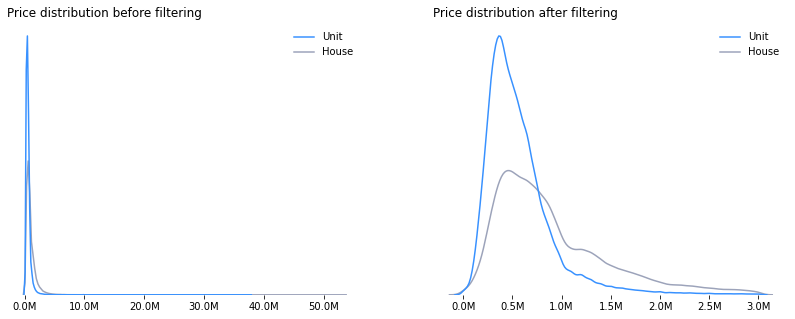

In [277]:
nrow, ncol = 1, 2
fig, axs = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 5))
axs = iter(axs.ravel())


def plot_dist(df, ax, title):
    sns.kdeplot(
        data=df,
        x="price",
        hue="property_type",
        ax=ax,
        palette= PALETTE_TWO_COLOR
    )
    decluter(ax, title=title, show_xaxis=True, x_use_million=True)


plot_dist(df_sel, next(axs), "Price distribution before filtering")
plot_dist(df, next(axs), "Price distribution after filtering")


In [278]:
debug(df.sale_type.unique())
debug(df.property_type.unique())


array(['Normal Sale'], dtype=object)

array(['Unit', 'House'], dtype=object)

In [279]:
# export as csv
df.to_csv(os.path.join(DATA_DIR, "dataset.csv"), index=False)


In summary, the following criterias were applied:

- sales record date: on or before 2021-12-31
- number of bedrooms: 0 to 5
- number of bathrooms: 1 to 5
- number of car parks: 0 to 3
- sale price: $1,000 to $3,000,000

In [280]:
md(
    f"""
The final dataset therefore contains {df.shape[0]:,} records ({df.shape[0]/df_raw.shape[0]:.0%} of the raw data).
"""
)



The final dataset therefore contains 600,451 records (82% of the raw data).


# Analysis

### General price trend

In [281]:
def get_median(df):
    # median by property type and year
    df_med = (
        df.drop(columns=["postcode"])
        .groupby(["property_type", "year"])
        .median()
        .reset_index()
    )
    # add rate of change column
    df_med["price_change"] = df_med.groupby(["property_type"]).price.diff() / df_med.price
    df_med.year = df_med.year.astype(int)
    return df_med
df_med= get_median(df)
debug(df_med.head())


,property_type,year,price,bedrooms,bathrooms,carparks,land_area,price_change
0,House,2000,328375.0,3.0,2.0,1.0,663.0,NaN
1,House,2001,372000.0,3.0,2.0,1.0,600.0,0.117272
2,House,2002,450000.0,3.0,2.0,1.0,600.0,0.173333
3,House,2003,528000.0,3.0,2.0,1.0,600.0,0.147727
4,House,2004,555000.0,3.0,2.0,1.0,604.0,0.048649


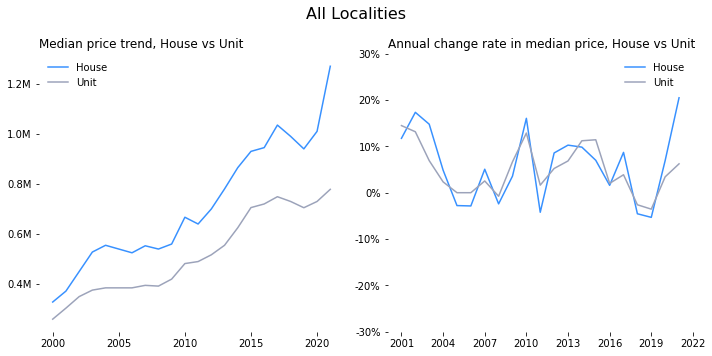

In [282]:
def plot_annual_trend(df, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs = iter(axs.ravel())
    ax = next(axs)
    sns.lineplot(
        data=df,
        x="year",
        y="price",
        hue="property_type",
        ax=ax,
        palette=PALETTE_TWO_COLOR,
    )
    decluter(
        ax,
        title="Median price trend, House vs Unit",
        show_xaxis=True,
        show_yaxis=True,
        y_use_million=True,
    )

    ax = next(axs)
    sns.lineplot(
        data=df,
        x="year",
        y="price_change",
        hue="property_type",
        ax=ax,
        palette=PALETTE_TWO_COLOR,
    )
    decluter(
        ax,
        title="Annual change rate in median price, House vs Unit",
        show_xaxis=True,
        show_yaxis=True,
        x_use_int=True,
    )
    ax.yaxis.set_major_formatter(lambda x, pos: f'{x:.0%}')
    ax.set_ylim(-0.3, 0.3)

    fig.tight_layout()
    fig.suptitle(title, size=16)
    fig.subplots_adjust(top=0.85)
    return fig


_ = plot_annual_trend(df_med, "All Localities")


In [283]:
md(f'''
General property price is trending upwards, median annual increment rate (since 2000) being {df_med.query('property_type =="House"').price_change.median():.1%} for Houses and {df_med.query('property_type =="Unit"').price_change.median():.1%} for Units.
''')


General property price is trending upwards, median annual increment rate (since 2000) being 6.9% for Houses and 3.9% for Units.


### Price trend by suburbs

In [284]:
# suburb coordinates
suburb_coord = pd.read_csv(os.path.join(AUS_PATH, "nsw_suburb_coord.csv"))
# calculate distance from CBD
CBD_COORD = (-33.8708, 151.2073)
suburb_coord["cbd_dist"] = suburb_coord.apply(
    lambda row: dist(row["lat"], row["lon"], CBD_COORD[0], CBD_COORD[1]), axis=1
)

# data grouped by suburb
df_sub = (
    df.groupby(["locality", "postcode", "property_type", "year"]).median().reset_index()
)
# merge to get coordinates
df_sub = df_sub.merge(suburb_coord, on="locality")
debug(suburb_coord.head())
debug(df_sub.head())


,locality,lat,lon,cbd_dist
0,DAWES POINT,-33.857222,151.206776,1.509879
1,SYDNEY,-33.869844,151.208285,0.152520
2,HAYMARKET,-33.881441,151.204452,1.224013
3,MILLERS POINT,-33.859913,151.204127,1.260095
4,THE ROCKS,-33.859992,151.208322,1.206338


,locality,postcode,property_type,year,price,bedrooms,bathrooms,carparks,land_area,lat,lon,cbd_dist
0,ABBOTSBURY,2176,House,2000,266000.0,4.0,2.0,2.0,697.0,-33.869285,150.866703,37.847524
1,ABBOTSBURY,2176,House,2001,403000.0,4.5,2.0,2.0,667.0,-33.869285,150.866703,37.847524
2,ABBOTSBURY,2176,House,2002,437500.0,4.0,2.0,2.0,600.5,-33.869285,150.866703,37.847524
3,ABBOTSBURY,2176,House,2003,470500.0,4.0,2.0,1.0,634.0,-33.869285,150.866703,37.847524
4,ABBOTSBURY,2176,House,2005,480000.0,4.0,2.0,2.0,699.0,-33.869285,150.866703,37.847524


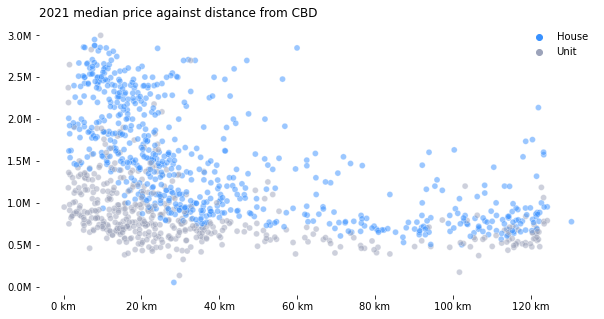

In [285]:
fig, ax = plt.subplots(figsize=(10, 5))
year = 2021
max_dist = 150
sns.scatterplot(
    data=df_sub.query(f"year=={year} & cbd_dist<={max_dist}"),
    x="cbd_dist",
    y="price",
    hue="property_type",
    alpha=0.5,
    ax=ax,
    palette=PALETTE_TWO_COLOR,
)
decluter(
    ax,
    show_xaxis=True,
    show_yaxis=True,
    y_use_million=True,
    title=f"{year} median price against distance from CBD",
)
ax.xaxis.set_major_formatter(lambda x, pos: f'{x:.0f} km')


Median prices of different suburbs were plotted against distance from Sydney CBD. It was observed that property prices for both Houses and Units generally drop off passed 40 km (about 1 hour drive).

In [286]:
bin_edges = [0, 10, 20, 30, 40, 60, 100]
labels = [f"{ed} km" for ed in bin_edges[1:]] + [f"{bin_edges[-1]}+ km"]
df_sub["dist_bin"] = pd.cut(df_sub.cbd_dist, bins=bin_edges + [np.inf], labels=labels)
debug(df_sub.dist_bin.unique())


['40 km', '10 km', '100+ km', '100 km', '30 km', '20 km', '60 km']
Categories (7, object): ['10 km' < '20 km' < '30 km' < '40 km' < '60 km' < '100 km' < '100+ km']

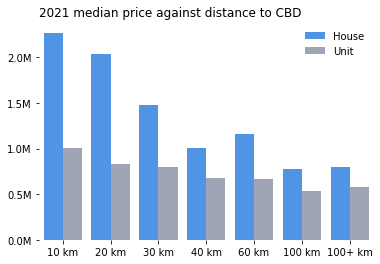

In [287]:
fig, ax = plt.subplots()
year = 2021
sns.barplot(
    data=df_sub.query(f"year=={year}")
    .groupby(["property_type", "dist_bin"])
    .median()
    .reset_index(),
    x="dist_bin",
    y="price",
    ax=ax,
    hue="property_type",
    palette=PALETTE_TWO_COLOR,
)
decluter(
    ax,
    show_yaxis=True,
    show_xaxis=True,
    y_use_million=True,
    title=f"{year} median price against distance to CBD",
)


For 2021, prices for Houses were significantly higher than Units within 30 km from Sydney CBD. Whereas prices for Units appeared to be far less affected by the distance.

In [288]:
CBD_RANGE = 35

md(f'''
### Suburbs closed to CBD
In this section, property sales within {CBD_RANGE} km of Sydney CBD were further analyzed.
''')


### Suburbs closed to CBD
In this section, property sales within 35 km of Sydney CBD were further analyzed.


In [289]:
# list of suburbs within 40km of CBD
cbd_subs= suburb_coord.query(f'cbd_dist<={CBD_RANGE}').locality.tolist()
# data of sales closed to CBD
df_cbd = df[df.locality.isin(cbd_subs)]
# median by property type and year
df_cbd_med = get_median(df_cbd)
debug(df_cbd_med.head())
debug(df_cbd.locality.nunique())

,property_type,year,price,bedrooms,bathrooms,carparks,land_area,price_change
0,House,2000,374000.0,3.0,2.0,1.0,690.0,NaN
1,House,2001,440000.0,3.0,2.0,1.0,607.0,0.150000
2,House,2002,532500.0,3.0,2.0,1.0,607.0,0.173709
3,House,2003,615000.0,3.0,2.0,1.0,607.0,0.134146
4,House,2004,640000.0,3.0,2.0,2.0,607.0,0.039062


436

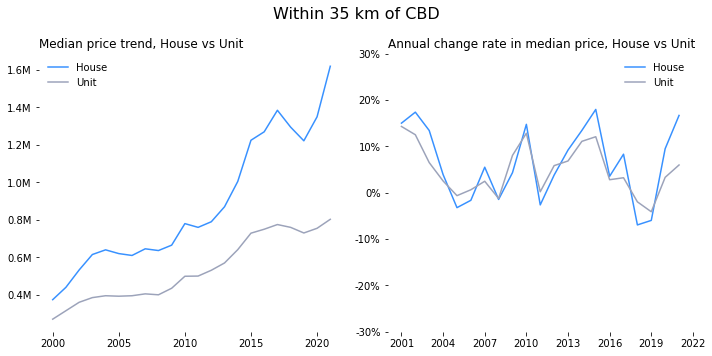

In [290]:
_=plot_annual_trend(df_cbd_med, title=f'Within {CBD_RANGE} km of CBD')

In [291]:
md(f'''
Property price for CBD suburb trends upwards similar to the general market, with median annual increment rate (since 2000) being {df_cbd_med.query('property_type =="House"').price_change.median():.1%} for Houses and {df_cbd_med.query('property_type =="Unit"').price_change.median():.1%} for Units.
''')


Property price for CBD suburb trends upwards similar to the general market, with median annual increment rate (since 2000) being 5.5% for Houses and 3.3% for Units.


##### Annual rate regression
To gauge the price increments on each CBD suburbs, linear regression model was fitted on data of each locality. Assuming that the annual rate of change of price is constant, the price model is therefore:

`log(year) ~ price`

In other words, it is assumed that prices of properties in a suburb increase by a constant percentage every year.

Note that only suburbs with properties sales in at least 9 years from 2000 to 2021 were considered.

In [292]:
# remove localities with too few sale records by year
active_locs = df_cbd.groupby('locality').nunique().query('year >=9').index.tolist()

In [293]:
N_YEAR_THRESHOLD =9

md(f'''
In total, {len(active_locs)} out of {df_cbd.locality.nunique()} CBD suburbs matches this criteria. Note that among these suburbs, in order to obtain sensible results, regression models were fitted only if there are more than {N_YEAR_THRESHOLD} years with sales for each property type (House or Unit). 
''')



In total, 410 out of 436 CBD suburbs matches this criteria. Note that among these suburbs, in order to obtain sensible results, regression models were fitted only if there are more than 9 years with sales for each property type (House or Unit). 


In [294]:
def log_regress(df, n_year_threshold= N_YEAR_THRESHOLD):
    # if number of years wtih sales is fewer than threshold, skip regression
    if df.year.nunique() <n_year_threshold:
        return None
    # model: log(price) ~ year
    model = LinearRegression()
    model.fit(X=np.array(df.year).reshape(-1, 1), y=np.log(df.price))
    results = pd.Series(
        (model.coef_[0], model.intercept_), index=["slope", "intercept"]
    )
    return results


results = df_cbd[df_cbd.locality.isin(active_locs)].groupby(["locality",'property_type']).apply(log_regress)
results['annual_rate']= np.exp(results.slope)-1
debug(results.head())

slope   intercept  annual_rate
locality      property_type                                   
ABBOTSFORD    House          0.079552 -145.971498     0.082802
              Unit           0.054118  -95.282965     0.055609
ALEXANDRIA    House          0.091973 -171.333594     0.096335
              Unit           0.052916  -93.245504     0.054341
ALFORDS POINT House          0.053281  -93.447095     0.054726

In [295]:
# annual_rates= results.unstack()
coeffs= results.reset_index()
# annual_rates.columns= ['_'.join(col_pair) for col_pair in annual_rates.columns]
# annual_rates= annual_rates.reset_index().melt(id_vars=['locality', 'property_type'])
debug(coeffs)

,locality,property_type,slope,intercept,annual_rate
0,ABBOTSFORD,House,0.079552,-145.971498,0.082802
1,ABBOTSFORD,Unit,0.054118,-95.282965,0.055609
2,ALEXANDRIA,House,0.091973,-171.333594,0.096335
3,ALEXANDRIA,Unit,0.052916,-93.245504,0.054341
4,ALFORDS POINT,House,0.053281,-93.447095,0.054726
...,...,...,...,...,...
787,YENNORA,Unit,0.040432,-68.717689,0.041260
788,YOWIE BAY,House,0.062577,-112.008653,0.064576
789,YOWIE BAY,Unit,0.057442,-101.683601,0.059123
790,ZETLAND,House,0.072546,-132.138415,0.075242


In [296]:
df_cbd_sub= df_cbd.groupby(['locality','postcode','property_type', 'year']).median().reset_index()
debug(df_cbd_sub)

,locality,postcode,property_type,year,price,bedrooms,bathrooms,carparks,land_area
0,ABBOTSFORD,2046,House,2000,825000.0,4.0,3.0,3.0,171.0
1,ABBOTSFORD,2046,House,2001,491500.0,2.0,1.0,1.0,895.0
2,ABBOTSFORD,2046,House,2002,760000.0,3.0,1.0,1.0,562.0
3,ABBOTSFORD,2046,House,2003,767500.0,2.5,1.5,1.5,840.5
4,ABBOTSFORD,2046,House,2004,163334.0,5.0,3.0,2.0,582.0
...,...,...,...,...,...,...,...,...,...
15301,ZETLAND,2017,Unit,2017,940500.0,2.0,2.0,1.0,105.5
15302,ZETLAND,2017,Unit,2018,936000.0,2.0,2.0,1.0,108.0
15303,ZETLAND,2017,Unit,2019,885000.0,2.0,2.0,1.0,130.5
15304,ZETLAND,2017,Unit,2020,910000.0,2.0,2.0,1.0,109.0


In [297]:
def fit_price(years, coeffs):
    # return fitted values for given years
    prices = np.exp(years * coeffs["slope"].values + coeffs["intercept"].values)
    df = pd.DataFrame(dict(year=years, price=prices))
    return df


def get_loc_fitted_price(df, coeffs, loc):
    # return df containing fitted price for houses and units of given locality
    prices_house = fit_price(
        df.query("property_type=='House'").year,
        coeffs.query(f"locality=='{loc}' & property_type=='House'"),
    )
    prices_unit = fit_price(
        df.query("property_type=='Unit'").year,
        coeffs.query(f"locality=='{loc}' & property_type=='Unit'"),
    )

    prices = pd.concat(
        [
            pd.DataFrame(
                dict(
                    property_type="House",
                    year=prices_house.year,
                    price=prices_house.price,
                )
            ),
            pd.DataFrame(
                dict(
                    property_type="Unit", year=prices_unit.year, price=prices_unit.price
                )
            ),
        ],
        axis=0,
    )
    return prices


def plot_loc_trend(df_plot, coeffs, ax, loc):
    sns.scatterplot(
        data=df_plot,
        x="year",
        y="price",
        hue="property_type",
        ax=ax,
        palette=PALETTE_TWO_COLOR,
    )
    fitted_prices = get_loc_fitted_price(df_plot, coeffs, loc)
    sns.lineplot(
        data=fitted_prices,
        x="year",
        y="price",
        hue="property_type",
        palette=PALETTE_TWO_COLOR,
        ax=ax,
        linestyle="--",
        legend=False,
    )

    # add label for annual rate
    fp= fitted_prices.set_index(['property_type', 'year'])
    cf= coeffs.set_index(['property_type', 'locality'])

    lab_x = df_plot.query('property_type=="House"').year.max()
    if ('House', loc) in cf.index and ('House', lab_x) in fp.index:
        lab_y= fp.at[('House', lab_x), 'price']
        rate=  cf.at[('House', loc), 'annual_rate']
        if not np.isnan(lab_y) and not np.isnan(rate):
            ax.text(
                lab_x + 0.5,
                lab_y,
                s=f"{rate:.1%}",
                ha="left",
                va="center",
                color=PALETTE_TWO_COLOR[0],
            )

    lab_x = df_plot.query('property_type=="Unit"').year.max()
    if ('Unit', loc) in cf.index and ('Unit', lab_x) in fp.index:
        lab_y= fp.at[('Unit', lab_x), 'price']
        rate=  cf.at[('Unit', loc), 'annual_rate']
        if not np.isnan(lab_y) and not np.isnan(rate):
            ax.text(
                lab_x + 0.5,
                lab_y,
                s=f"{rate:.1%}",
                ha="left",
                va="center",
                color=PALETTE_TWO_COLOR[1],
            )

    # limit axis for comparison
    ax.set_ylim(0, 3e6)
    ax.set_xlim(2000,2022)
    decluter(
        ax,
        show_xaxis=True,
        show_yaxis=True,
        y_use_million=True,
        x_use_int=True,
        title=f"{loc.title()}",
    )


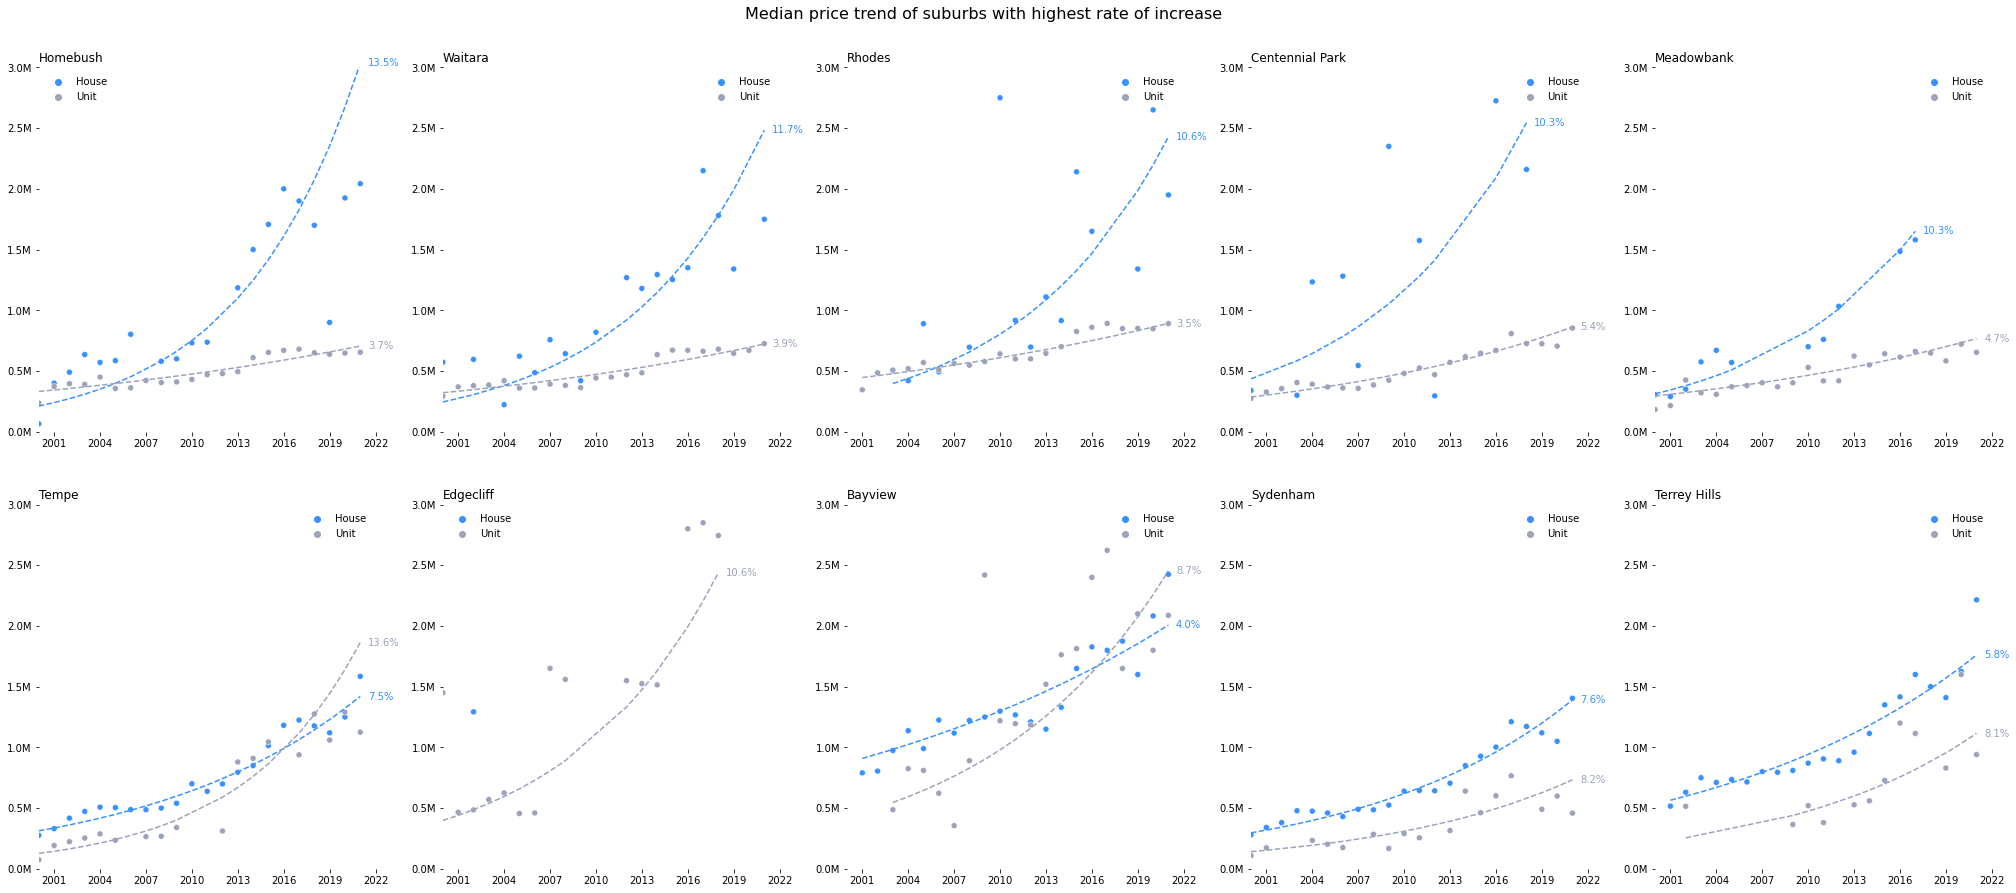

In [298]:
# localities with top House annual rate
fig, axs = plt.subplots(2, 5, figsize=(35, 14))
axs = iter(axs.ravel())

top_house_locs = (
    coeffs.query('property_type=="House"')
    .sort_values("annual_rate", ascending=False)
    .head(5)
    .locality
)
top_unit_locs = (
    coeffs.query('property_type=="Unit"')
    .sort_values("annual_rate", ascending=False)
    .head(5)
    .locality
)
for loc in top_house_locs:
    ax= next(axs)
    df_plot = df_cbd_sub.query(f"locality=='{loc}'")
    plot_loc_trend(df_plot, coeffs, ax, loc)

for loc in top_unit_locs:
    ax= next(axs)
    df_plot = df_cbd_sub.query(f"locality=='{loc}'")
    plot_loc_trend(df_plot, coeffs,  ax, loc)
 
fig.suptitle('Median price trend of suburbs with highest rate of increase', size=16)
fig.subplots_adjust(top=0.92)


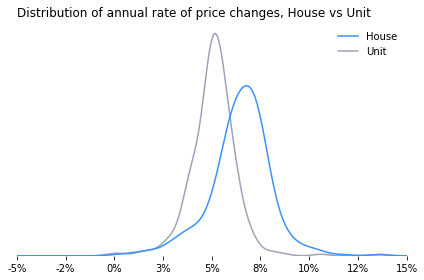

In [299]:
fig, ax = plt.subplots()
sns.kdeplot(data=coeffs, hue='property_type', x='annual_rate', ax=ax, palette=PALETTE_TWO_COLOR)
ax.set_xlim(-0.05, 0.15)
ax.xaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")
decluter(ax, show_xaxis=True, title= 'Distribution of annual rate of price changes, House vs Unit')
fig.tight_layout()

In [300]:
df_cbd.groupby(['property_type', 'locality' , 'year']).median().reset_index(level=2)

year     price  bedrooms  bathrooms  carparks  \
property_type locality                                                    
House         ABBOTSFORD  2000  825000.0       4.0        3.0       3.0   
              ABBOTSFORD  2001  491500.0       2.0        1.0       1.0   
              ABBOTSFORD  2002  760000.0       3.0        1.0       1.0   
              ABBOTSFORD  2003  767500.0       2.5        1.5       1.5   
              ABBOTSFORD  2004  163334.0       5.0        3.0       2.0   
...                        ...       ...       ...        ...       ...   
Unit          ZETLAND     2017  940500.0       2.0        2.0       1.0   
              ZETLAND     2018  936000.0       2.0        2.0       1.0   
              ZETLAND     2019  885000.0       2.0        2.0       1.0   
              ZETLAND     2020  910000.0       2.0        2.0       1.0   
              ZETLAND     2021  940000.0       2.0        2.0       1.0   

                          postcode  land_area  
property_type locality                         
House         ABBOTSFORD    2046.0      171.0  
              ABBOTSFORD    2046.0      895.0  
              ABBOTSFORD    2046.0      562.0  
              ABBOTSFORD    2046.0      840.5  
              ABBOTSFORD    2046.0      582.0  
...                            ...        ...  
Unit          ZETLAND       2017.0      105.5  
              ZETLAND       2017.0      108.0  
              ZETLAND       2017.0      130.5  
              ZETLAND       2017.0      109.0  
              ZETLAND       2017.0      112.0  

[15306 rows x 7 columns]